In [50]:
pathmc="/eos/user/h/hsharma/PythiaFIles/dummySets/mc_events.csv"
pathdata="/eos/user/h/hsharma/PythiaFIles/dummySets/real_events.csv"


import numpy as np
import pandas as pd
import matplotlib as plt
# Set random seed for reproducibility
np.random.seed(42)

# Number of events
N_real = 10000  # Real dataset size
N_mc = 10000    # MC dataset size

# Generate "real" event data (from a slightly different true distribution)
real_pT = np.random.normal(loc=50, scale=10, size=N_real)  # Centered at 50 GeV
real_y = np.random.normal(loc=0, scale=1, size=N_real)      # Centered at 0
real_m = np.random.normal(loc=200, scale=20, size=N_real)   # Mass around 200 GeV

# Generate "MC" event data (with slight systematic shift)
mc_pT = np.random.normal(loc=52, scale=11, size=N_mc)  # Shifted mean + wider spread
mc_y = np.random.normal(loc=0.1, scale=1.1, size=N_mc)  # Small shift in rapidity
mc_m = np.random.normal(loc=195, scale=22, size=N_mc)   # Mass shifted down

# Create pandas DataFrames
real_data = pd.DataFrame({"pT": real_pT, "y": real_y, "m": real_m})
mc_data = pd.DataFrame({"pT": mc_pT, "y": mc_y, "m": mc_m})

# Save to CSV files
real_data_path = "/mnt/data/real_events.csv"
mc_data_path = "/mnt/data/mc_events.csv"

real_data.to_csv(pathmc, index=False)
mc_data.to_csv(pathdata, index=False)



array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

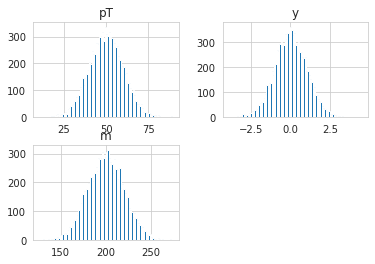

In [51]:
real_data[['pT','y','m']].hist(bins=100)

array([[<Axes: title={'center': 'pT'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'm'}>, <Axes: >]], dtype=object)

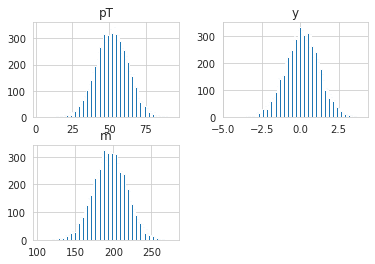

In [53]:
mc_data[['pT','y','m']].hist(bins=100)

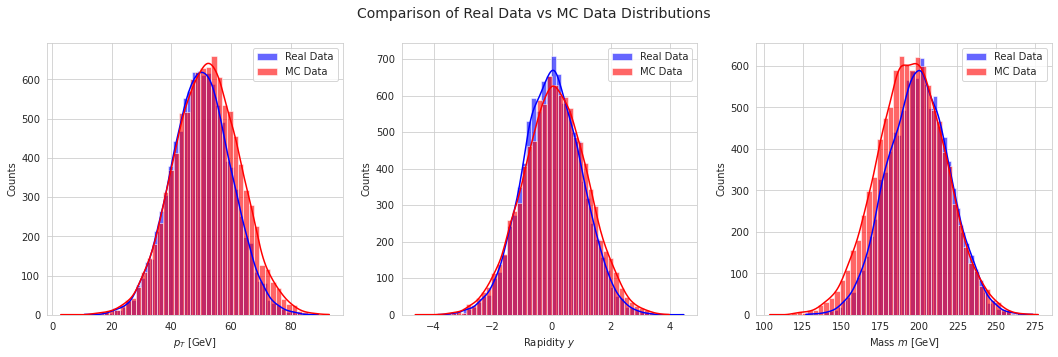

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define variable names and labels
variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

# Plot distributions
for i, var in enumerate(variables):
    sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC Data", ax=axes[i], alpha=0.6)
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

# Show the plots
plt.suptitle("Comparison of Real Data vs MC Data Distributions", fontsize=14)
plt.show()


In [56]:
from sklearn.preprocessing import StandardScaler
# Normalize data
scaler = StandardScaler()
real_data_scaled = scaler.fit_transform(real_data)
real_data_scaled = pd.DataFrame(real_data_scaled, columns=real_data.columns)

mc_data_scaled = scaler.fit_transform(mc_data)
mc_data_scaled = pd.DataFrame(mc_data_scaled, columns=mc_data.columns)



In [57]:
import sys
sys.path.append('/eos/home-i02/h/hsharma/.local/lib/python3.9/site-packages')
from pzflow import Flow
from pzflow.bijectors import NeuralSplineCoupling


# Define a normalizing flow
# flow = Flow(data_columns=["pT", "y", "m"])  # 3 features (pT, y, m)
# Define a more complex normalizing flow
flow = Flow(
    data_columns=["pT", "y", "m"], 
    bijector=NeuralSplineCoupling()
)

flow.train(real_data_scaled, epochs=100, verbose=True, batch_size=16)


Training 100 epochs 
Loss:
(0) 6.9997
(1) 5.2015
(6) 5.1694
(11) 5.1472
(16) 5.1667
(21) 5.1413
(26) 5.1358
(31) 5.1459
(36) 5.1371
(41) 5.1355
(46) 5.1362
(51) 5.1332
(56) 5.1486
(61) 5.1356
(66) 5.1304
(71) 5.1365
(76) 5.1283
(81) 5.1293
(86) 5.1267
(91) 5.1239
(96) 5.1286
(100) 5.1226


[6.999689102172852,
 5.201455593109131,
 5.169182777404785,
 5.173665523529053,
 5.151885032653809,
 5.159032821655273,
 5.169448375701904,
 5.152180194854736,
 5.162059307098389,
 5.159924030303955,
 5.239934921264648,
 5.147152900695801,
 5.145910263061523,
 5.146953105926514,
 5.157443523406982,
 5.142319679260254,
 5.166731834411621,
 5.161520004272461,
 5.142355442047119,
 5.151322364807129,
 5.154818534851074,
 5.141266822814941,
 5.139516830444336,
 5.142635345458984,
 5.141284942626953,
 5.138053894042969,
 5.13581657409668,
 5.142063617706299,
 5.1398162841796875,
 5.136886119842529,
 5.137269020080566,
 5.145908832550049,
 5.139638900756836,
 5.143068313598633,
 5.1389360427856445,
 5.134888172149658,
 5.137059211730957,
 5.1396484375,
 5.134253025054932,
 5.141208648681641,
 5.135058403015137,
 5.135470390319824,
 5.1361985206604,
 5.135300159454346,
 5.1334428787231445,
 5.144936561584473,
 5.1362457275390625,
 5.134230136871338,
 5.134331703186035,
 5.131896495819092,
 5.1

In [73]:
# Compute log probability densities for real and simulated events
log_prob_real = flow.log_prob(real_data_scaled)
log_prob_mc = flow.log_prob(mc_data_scaled)
weights = np.exp(log_prob_real - log_prob_mc)

weights = np.tanh(weights / np.max(weights))


# Apply weights to reweight PYTHIA events
mc_data["weights"] = weights

# Save reweighted events
mc_data.to_csv("reweighted_mc_events.csv", index=False)

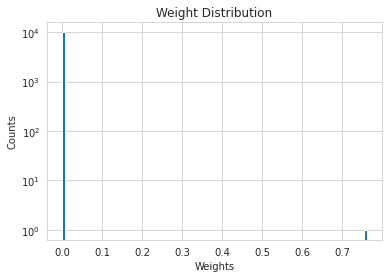

In [75]:
import matplotlib.pyplot as plt
plt.hist(weights, bins=100, log=True)
plt.xlabel("Weights")
plt.ylabel("Counts")
plt.title("Weight Distribution")
plt.show()

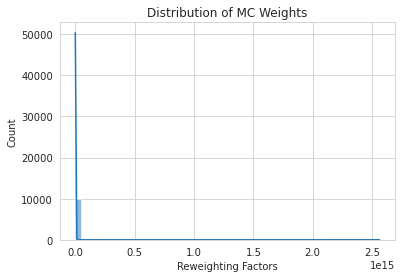

float64


In [60]:
sns.histplot(mc_data["weights"], bins=50, kde=1)
plt.xlabel("Reweighting Factors")
plt.ylabel("Count")
plt.title("Distribution of MC Weights")
plt.show()
print(mc_data["weights"].dtype)  # Should be float64 or int64

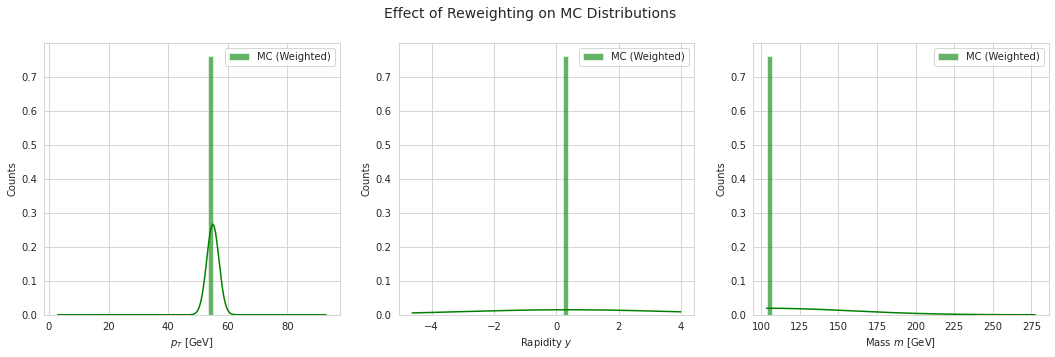

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variables = ["pT", "y", "m"]
labels = [r"$p_T$ [GeV]", r"Rapidity $y$", r"Mass $m$ [GeV]"]

for i, var in enumerate(variables):
    #sns.histplot(real_data[var], bins=50, kde=True, color="blue", label="Real Data", ax=axes[i], alpha=0.6)
    #sns.histplot(mc_data[var], bins=50, kde=True, color="red", label="MC (Unweighted)", ax=axes[i], alpha=0.3)
#     sns.histplot(mc_data[var], bins=50, kde=True, weights=mc_data["weights"], color="green", label="MC (Weighted)", ax=axes[i], alpha=0.6)
    sns.histplot(data=mc_data, x=var, bins=50, kde=True, weights=mc_data["weights"], color="green", label="MC (Weighted)", ax=axes[i], alpha=0.6)

    
    axes[i].set_xlabel(labels[i])
    axes[i].set_ylabel("Counts")
    axes[i].legend()

plt.suptitle("Effect of Reweighting on MC Distributions", fontsize=14)
plt.show()
